# 6. Visual Search - Azure Cognitive Search Index Generation

<img src="https://github.com/retkowsky/images/blob/master/visualsearchlogo.jpg?raw=true">

# Visual Search with Azure Cognitive Search, Sentence Transformers, Azure Computer Vision and bar code/QR code detection

## Description
The goal of this is **Azure AI asset is to enable search over Text and Images using Azure Cognitive Search**. The technique was inspired by a research article which show how to **convert vectors (embeddings) to text which allows the Cognitive Search service to leverage the inverted index to quickly find the most relevant items**. For this reason, any model that will convert an object to a vector can be leveraged if the number of dimensions in the resulting vector is less than 3,000. It also allows users to leverage existing pretrained or fine-tuned models.<br><br>

This technique has shown to be incredibly effective and easy to implement. We are using **Sentence Transformers, which is an OpenAI clip model wrapper**. We need to embed all our existing catalog of images. Then the objects embedding are converted into a set of fake terms and all the results are stored into an Azure Cognitive Search index for handling all the search requests.
For example, if an embedding looked like [-0,21, .123, ..., .876], this might be converted to a set of fake terms such as: “A1 B3 … FED0”. This is what is sent as the search query to Azure Cognitive Search.<br><br>

We can **enrich the Azure Cognitive Search index by using extracted text from the images using Azure Read API**. We can also detect and extract any information from **bar code and/or QR code** that might be available in the products catalog images. And we can use also **Azure Computer Vision as well to detect the dominant colors of the image, the tags that can describe the image and the caption of each image**. All these information will be ingested into the Azure Cognitive Search index.<br><br>

The goal of this asset is to be able to use the inverted index within Azure Cognitive Search to be able to quickly find vectors stored in the search index that are like a vector provided as part of a search query and/or using any AI extracted information (text, dominant colors, …). Unlike techniques like cosine similarity which are slow to process large numbers of items, this leverages an inverted index which enables much more data to be indexed and searched.<br>

## Process

- We have here a collection of catalog images (466 images).
- For each of these images, we will embed them using Sentence Transformers.  Sentence Transformer can be used to map images and texts to the same vector space. As model, we use the OpenAI CLIP Model which was trained on a large set of images and image alt texts.
- We can retrieve any text from these images using Azure Read API (if any text is available)
- We can retrieve any text information from any bar code or QR code (if any)
- All these information will be ingested into an Azure Cognitive Search index
- Then if you have a field image, you can embed it and extract any text/barcode information and call the Azure Cognitive Search index to retrieve any similar images using vecText similarity and/or using any query text from the extracted text


<img src="https://github.com/retkowsky/images/blob/master/process.png?raw=true">

Field images are available in the field images directory (number of images=53)


## Azure products documentation
- https://azure.microsoft.com/en-us/products/search/ 
- https://azure.microsoft.com/en-us/products/cognitive-services/computer-vision/#overview 
- https://learn.microsoft.com/en-us/azure/cognitive-services/Computer-vision/how-to/call-read-api 
- https://zbar.sourceforge.net/ 
- https://github.com/liamca/vector-search

## Research article
https://www.researchgate.net/publication/305910626_Large_Scale_Indexing_and_Searching_Deep_Convolutional_Neural_Network_Features
    
## Directories
- **images**: We have two directories (catalog images, field images)
- **model**: Directory to save the clusters of the model
- **results**: Directory to save some results
- **test**: Directory that contains some testing images

## Python notebooks

### 0. Settings.ipynb
Notebook that contains the link to the images and the importation process of the python required libraries

### 1. Catalog images exploration.ipynb
This notebook will display some catalog and field images

### 2. OpenAI Clip and VecText Clusters.ipynb
This notebook will explain what sentence transformers is and will generate the clusters
This notebook analyzes a set of existing images to determine a set of "cluster centers" that will be used to determine which "fake words" are generated for a vector
This notebook will take a test set of files (testSamplesToTest) and determine the optimal way to cluster vectors into fake words that will be indexed into Azure Cognitive Search

### 3. VecText generation.ipynb
This notebook will generate the vectext embedding for all the catalog images

### 4. BarCode Information extraction.ipynb
This notebook will detect any barcode or QR code from the catalog images and will extract the information

### 5. Azure CV for OCR, tags, colors and captions.ipynb
This notebook will use Azure Computer Vision or OCR, colors, tags and caption extraction for each of the catalog images.

### 6. Azure Cognitive Search Index Generation.ipynb
This notebook will show how to ingest all the information into an Azure Cognitive Search index.

### 7. Calling Azure Cognitive Search.ipynb
We can now test the index using some images similarity visual search or free text queries using azure Cognitive Search.

## Python files

- **azureCognitiveSearch.py**
This python file contains many functions to manage and use Azure Cognitive Search

- **myfunctions.py**
This python file contains many generic functions used in all the notebooks

- **vec2Text.py**
This python file contains some functions for the sentence transformers model


24-oct-2022 Serge Retkowsky | serge.retkowsky@microsoft.com | https://www.linkedin.com/in/serger/

In [1]:
import configparser
import json
import sys
import requests
import pandas as pd
import time

import vec2Text
import azureCognitiveSearch as acs
import myfunctions as my

%matplotlib inline

In [2]:
my.view_file('azureCognitiveSearch.py')

Viewing file: azureCognitiveSearch.py 

# Azure Cognitive Search python functions
# 20-Oct-2022


# Multiple imports
import os
import configparser
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import vec2Text

import myfunctions as my

from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents import SearchClient
from azure.search.documents.indexes.models import (
    ComplexField,
    CorsOptions,
    SearchIndex,
    ScoringProfile,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
)
from IPython.display import Image


# Azure Cognitive Search connection
config_file = 'azureservices.py'

# Azure Cognitive Search Index name
index_name = "demo-retail"

# Azure Cognitive Search credentials
config = configparser.ConfigParser()
config.read(config_file)
acs_key = config.get('AzureCognitiveSearch', 'key')
acs_endpoint = config.get('Azure

In [3]:
my.view_file('vec2Text.py')

Viewing file: vec2Text.py 

# Vec2Text functions
# 20-Oct-2022


# Multiple imports
import base64
import collections
import gensim
import glob
import math
import numpy as np
import os
import random
import shutil

from os import listdir
from os.path import isfile, join
from pathlib import Path
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from shutil import rmtree
from sklearn.cluster import KMeans


# Functions definitions


def calculate_dimensions(file, model):
    """
    Calculate dimensions
    """
    return image_embedding(file, model).shape[0]


def calculate_wcss(data):
    """
    Clustering K Means algorithm from sci-kit learn
    """
    data = np.array(data).reshape(-1, 1)
    wcss = []

    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss


def convert_vec_to_bucket_str(curVec, bucketRanges):
    """
    Convert Vect Text To Bucket string
    ""

In [4]:
print("Today is:", my.get_today())

Today is: 24-10-2022 15:04:49


Storage:

Total: 126.8 GB
- Used: 66.4 GB | 52.37 %
- Free: 60.4 GB | 47.61 %


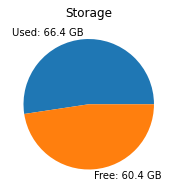

(126774263808, 66395750400, 60361736192)

In [5]:
my.get_storage_infos()

## 1. Images

In [6]:
IMAGES_DIR = "./images/catalog_images"

In [7]:
files = vec2Text.get_files_in_dir(IMAGES_DIR)
print('Total number of images Catalog files:', len(files))

Total number of images Catalog files: 466


## 2. Processing results

In [8]:
RESULTS_DIR = "results"
pd.reset_option('display.max_rows')

In [9]:
my.list_dir(RESULTS_DIR)

Files in directory: results 

1 	 2022-10-24 14:48:44.006870 27.1 kB 	 barcode_catalog_results.pkl
2 	 2022-10-24 14:48:43.851959 23.8 kB 	 barcode_catalog_results.png
3 	 2022-10-24 14:48:34.347439 1.1 MB 	 barcode_result1.jpg
4 	 2022-10-24 15:03:32.351564 33.5 kB 	 caption_catalog_results.pkl
5 	 2022-10-24 15:03:32.129692 30.1 kB 	 colors_catalog_results.pkl
6 	 2022-10-24 15:03:31.974781 198.3 kB 	 ocr_catalog_results.pkl
7 	 2022-10-24 15:03:31.695942 25.6 kB 	 ocr_catalog_results.png
8 	 2022-10-24 15:03:32.220640 44.0 kB 	 tags_catalog_results.pkl
9 	 2022-10-24 14:41:06.619912 1.2 MB 	 vectext_catalog_results.pkl
10 	 2022-10-24 14:41:06.400039 23.4 kB 	 vectext_catalog_results.png


In [10]:
df_vectext = pd.read_pickle(RESULTS_DIR + "/vectext_catalog_results.pkl")
df_barcode = pd.read_pickle(RESULTS_DIR + "/barcode_catalog_results.pkl")
df_ocr = pd.read_pickle(RESULTS_DIR + "/ocr_catalog_results.pkl")
df_colors = pd.read_pickle(RESULTS_DIR + "/colors_catalog_results.pkl")
df_tags = pd.read_pickle(RESULTS_DIR + "/tags_catalog_results.pkl")
df_captions = pd.read_pickle(RESULTS_DIR + "/caption_catalog_results.pkl")

In [17]:
from functools import reduce

dfs = [df_vectext, df_barcode, df_ocr, df_colors, df_tags, df_captions]

df = reduce(lambda left,
            right: pd.merge(left,
                            right,
                            on=['imagefile'],
                            how='outer'), 
            dfs)

In [18]:
df.head()

,imagefile,vectext,barcodetext,ocrtext,img_colors,img_tags,img_caption
0,./images/catalog_images/catalog_image_00001.jpg,A2 B0 C1 D5 E2 F3 G0 H2 I1 J1 BA1 BB3 BC3 BD4 ...,,FABRIQUÉ EN FRANCE La Mère Poulard La Grande G...,Grey White,text fast food snack food,a box of cookies
1,./images/catalog_images/catalog_image_00002.jpg,A2 B3 C1 D4 E2 F3 G3 H3 I3 J2 BA1 BB0 BC2 BD0 ...,,yaourt Nature MALO,Grey White,text tin,a can of food
2,./images/catalog_images/catalog_image_00003.jpg,A1 B3 C3 D3 E3 F0 G1 H3 I4 J2 BA4 BB1 BC1 BD3 ...,,EST. 1907 SAXA SEA SALT NO NEED TO GRIND FINE,Grey,tin can soft drink plastic drink lid indoor ti...,a blue and white container
3,./images/catalog_images/catalog_image_00004.jpg,A2 B3 C1 D3 E3 F2 G2 H3 I4 J1 BA3 BB1 BC2 BD2 ...,,SAXA SEA SALT FINE 960EQL-6866105,Grey,indoor text tin can tin cup,a blue and white container
4,./images/catalog_images/catalog_image_00005.jpg,A2 B3 C0 D2 E2 F0 G2 H3 I3 J1 BA2 BB0 BC2 BD2 ...,,SAXA SEA SALT FINE 5 019989 103096,Grey White,text indoor tin can household supply tin wall ...,a blue can of energy drink


In [19]:
noval = (df['vectext'] == '').sum()
nobs = df_ocr.shape[0]
withtext = nobs - noval

print("Number of empty vectext text =", noval)
print("Number of empty vectext text in % =", round(noval / nobs * 100, 2))
print("Number of detected vectext text =", withtext)
print("Number of detected vectext text in % =", round(withtext / nobs * 100,
                                                      2))

Number of empty vectext text = 0
Number of empty vectext text in % = 0.0
Number of detected vectext text = 466
Number of detected vectext text in % = 100.0


In [20]:
noval = (df['barcodetext'] == '').sum()
nobs = df_ocr.shape[0]
withtext = nobs - noval

print("Number of empty barcodetext text =", noval)
print("Number of empty barcodetext text in % =", round(noval / nobs * 100, 2))
print("Number of detected barcodetext text =", withtext)
print("Number of detected barcodetext text in % =",
      round(withtext / nobs * 100, 2))

Number of empty barcodetext text = 389
Number of empty barcodetext text in % = 83.48
Number of detected barcodetext text = 77
Number of detected barcodetext text in % = 16.52


In [21]:
noval = (df['ocrtext'] == '').sum()
nobs = df_ocr.shape[0]
withtext = nobs - noval

print("Number of empty ocrtext text =", noval)
print("Number of empty ocrtext text in % =", round(noval / nobs * 100, 2))
print("Number of detected ocrtext text =", withtext)
print("Number of detected ocrtext text in % =", round(withtext / nobs * 100,
                                                      2))

Number of empty ocrtext text = 31
Number of empty ocrtext text in % = 6.65
Number of detected ocrtext text = 435
Number of detected ocrtext text in % = 93.35


## 3. Azure Cognitive Search Index

In [22]:
config_file = 'azureservices.py'
config = configparser.ConfigParser()
config.read(config_file)
search_key = config.get('AzureCognitiveSearch', 'key')
search_endpoint = config.get('AzureCognitiveSearch', 'endpoint')
search_servicename = config.get('AzureCognitiveSearch', 'servicename')

In [25]:
print("Your credentials (values have been masked for privacy)")
print("Azure Cognitive Search endpoint:",
      search_endpoint[:10] + "************" + search_endpoint[-10:])
print("Azure Cognitive Search key:",
      search_key[:2] + "************" + search_key[-2:])

Your credentials (values have been masked for privacy)
Azure Cognitive Search endpoint: https://az************indows.net
Azure Cognitive Search key: 0C************C6


In [26]:
print("Azure Cognitive Search service:", search_servicename[:3] + '****')
print("Azure Cognitive Search index is:", acs.index_name)

Azure Cognitive Search service: azu****
Azure Cognitive Search index is: demo-retail


### Deleting index

In [27]:
print(my.now())
acs.delete_index()

2022-10-24T17:09:40.946269+02:00
Deleting index demo-retail
demo-retail index has been deleted


### Creating new empty index

In [28]:
print(my.now())
acs.create_index()

2022-10-24T17:09:43.541433+02:00
Creating new index demo-retail
demo-retail index has been created


## 4. Loading data into the Azure Cognitive Search index

In [29]:
max_batch_size = 100
documents = []
idx = 0
debugmode = False
ocrtext = ''
start = my.now()

print("Uploading images to Azure Cognitive Search...")
print("\nUsing max_batch_size =", max_batch_size)
nbimagesfiles = len(files)
print('Number of images files to load:', nbimagesfiles, "\n")

for file in files:  # Reading image by image (fullpath image)
    file = df['imagefile'].iloc[idx]
    vecText = df['vectext'].iloc[idx]
    ocrtext = df['ocrtext'].iloc[idx]
    barcodetext = df['barcodetext'].iloc[idx]
    colors = df['img_colors'].iloc[idx]
    tags = df['img_tags'].iloc[idx]
    caption = df['img_caption'].iloc[idx]

    if debugmode:
        print(file)
        print(vecText)
        print(ocrtext)
        print(barcodetext)
        print(colors)
        print(tags)
        print(caption)
    
    # Adding all fields to the documents
    documents.append({
        "@search.action": "upload",
        "Id": vec2Text.string_to_base64(file),  # Image file id
        "Content": file,  # filename
        "VecText": vecText,  # vec2text results
        "Ocrtext":
        ocrtext,  # get text from image using Azure OCR (if there are some text, otherwise blank)
        "Barcodetext":
        barcodetext,  # Get text from barcode (if there is one, otherwise blank)
        "Colors": colors,  # Get Azure CV colors detection
        "Tags": tags,  # Get Azure CV tags
        "Caption": caption,  # Get Azure CV caption
    })

    idx += 1

    if len(documents) == max_batch_size:
        if debugmode:
            print(documents)

        acs.upload_documents(documents)
        documents = []
        pct_done = (idx / nbimagesfiles) * 100
        pct_todo = 100 - pct_done
        print(my.get_today(), 'Elapsed time in min:', (my.now() - start) / 60,
              ' : Number of processed images:', idx, "/",
              nbimagesfiles, '| Done:', round(pct_done), "%", '| To do:',
              round(pct_todo, 1), '%', "\n")

if len(documents) > 0:
    acs.upload_documents(documents)
    print('\nNumber of processed files =', idx)

print("Done in", (my.now() - start).in_words(locale='en'))

Uploading images to Azure Cognitive Search...

Using max_batch_size = 100
Number of images files to load: 466 

Uploading new document...
Upload of new document succeeded: True
Done

24-10-2022 15:09:52 Elapsed time in min: 0.02 second  : Number of processed images: 100 / 466 | Done: 21 % | To do: 78.5 % 

Uploading new document...
Upload of new document succeeded: True
Done

24-10-2022 15:09:52 Elapsed time in min: 0.02 second  : Number of processed images: 200 / 466 | Done: 43 % | To do: 57.1 % 

Uploading new document...
Upload of new document succeeded: True
Done

24-10-2022 15:09:53 Elapsed time in min: 0.03 second  : Number of processed images: 300 / 466 | Done: 64 % | To do: 35.6 % 

Uploading new document...
Upload of new document succeeded: True
Done

24-10-2022 15:09:53 Elapsed time in min: 0.04 second  : Number of processed images: 400 / 466 | Done: 86 % | To do: 14.2 % 

Uploading new document...
Upload of new document succeeded: True
Done


Number of processed files = 466


## 5. Azure Cognitive Search Index status

In [30]:
print("Azure Cognitive Search index name:", acs.index_name)

Azure Cognitive Search index name: demo-retail


In [31]:
acs.index_status(acs.index_name)

Azure Cognitive Search Index: demo-retail 

{
    "@odata.context": "https://azurecognitivesearchsr.search.windows.net/$metadata#indexes/$entity",
    "@odata.etag": "\"0x8DAB5D1C886D578\"",
    "name": "demo-retail",
    "defaultScoringProfile": null,
    "fields": [
        {
            "name": "Id",
            "type": "Edm.String",
            "searchable": false,
            "filterable": false,
            "retrievable": true,
            "sortable": false,
            "facetable": false,
            "key": true,
            "indexAnalyzer": null,
            "searchAnalyzer": null,
            "analyzer": null,
            "synonymMaps": []
        },
        {
            "name": "Content",
            "type": "Edm.String",
            "searchable": true,
            "filterable": true,
            "retrievable": true,
            "sortable": true,
            "facetable": false,
            "key": false,
            "indexAnalyzer": null,
            "searchAnalyzer": null,
 

> End of notebook